# Import libraries

In [96]:
import pyautogui
import gi
gi.require_version("Wnck", "3.0")
from gi.repository import Wnck

from IPython.display import clear_output
from time import sleep

import matplotlib.pyplot as plt

from collections import deque
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

import numpy as np

import time

# FIRST OF ALL : Run the game
``` bash
cd ./FlappyBirdGame
python ./flappy.py
```

# Game Class

In [105]:
class FlappyBirdGame :
    def __init__(self, windowName):
        scr = Wnck.Screen.get_default()
        scr.force_update()
        windows = scr.get_windows()
        self.flappyBird_window = None
        for window in windows:
            # if title is "Flappy Bird"
            if window.get_name() == windowName:
                # get the window's geometry
                x, y, width, height = window.get_geometry()
                self.flappyBird_window = { "x": x, "y": y, "width": width, "height": height }
                print("Game Positions ↓\n - x :", x , "\n - y :", y , "\n - width :", width , "\n - height :", height)
        if self.flappyBird_window is None:
            print("Window not found")
        else :
            self.flappyBird_click = ( self.flappyBird_window["x"] + self.flappyBird_window["width"]/2, self.flappyBird_window["y"] + self.flappyBird_window["height"] - 30 )
            # focus window
            self.focus()
            # first click
            self.get_processed_img()
            # init start time
            self.start_time = time.time()
            # init score
            self.score = 0
    
    def focus(self):
        pyautogui.moveTo(self.flappyBird_click)
        pyautogui.click()
    
    def up(self):
        pyautogui.press('space')
    
    def get_img(self):
        # make a screenshot of the window
        self.img = pyautogui.screenshot(region=(self.flappyBird_window["x"], self.flappyBird_window["y"], self.flappyBird_window["width"], self.flappyBird_window["height"]))
        return self.img
    
    def get_processed_img(self):
        # make a screenshot of the window
        img = self.get_img()
        # convert image to gray scale
        img = img.convert('L')
        # crop top and bottom of the image
        img = img.crop((0, 35, img.width, img.height - 105))
        # scale image to 60x60
        img = img.resize((60, 60))
        # save processed image
        self.processed_img = img
        # return the image
        return img
    
    def is_end(self): # True if game over, else False
        bottom_line_nbr = self.img.height - 108 # 108 pixel from the bottom of the screen
        img = self.img.crop((50, bottom_line_nbr, 100, bottom_line_nbr + 1))
        # test if one pixel is not (84, 56, 71) -> it's lose
        for x in range(img.width):
            if img.getpixel((x, 0)) != (84, 56, 71):
                return True
        return False
    
    def startRound(self):
        # wait 2 seconds
        sleep(2)
        # focus window
        self.focus()
        # first click
        self.get_processed_img()
        # init score
        self.score = 0
        # start game
        self.up()
        # start timer
        self.start_time = time.time()
    
    def get_score(self):
        # get time
        cur_time = time.time()
        # if the game started more than 3 second ago
        if cur_time - self.start_time > 2.9:
            # the score is the time left before the next tube
            if cur_time - self.last_reward_time < 1:
                self.score = 1 - cur_time - self.last_reward_time
            else :
                self.last_reward_time = cur_time
        return self.score
        

    def play(self, action):
        if action == 1:
            self.up()
        # wait 0.05 second
        sleep(0.05)
        img = self.get_processed_img()
        end = self.is_end()
        if end:
            reward = -1
        else :
            reward = self.get_score()
        return img, self.get_score(), end
        

In [81]:
# Create the game instance
game = FlappyBirdGame("Flappy Bird")

Game Positions ↓
 - x : 1594 
 - y : 102 
 - width : 288 
 - height : 549


# Some Tests

### Test end of game

In [82]:
print(game.is_end())

True


### Test screen capture

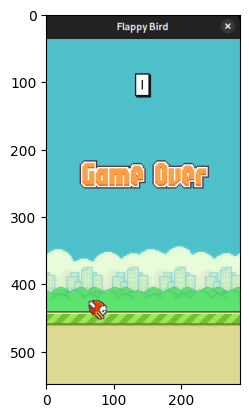

In [84]:
plt.imshow(game.img)

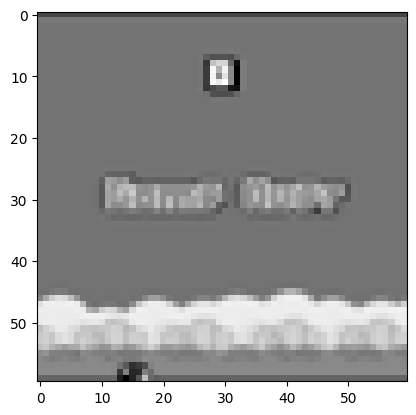

In [85]:
# print image

plt.imshow(game.processed_img, cmap='gray')

# while True :
#     # clear output
#     clear_output(wait=True)
#     plt.imshow(game.get_processed_img(), cmap='gray')
#     plt.show()
#     sleep(1)

### Test screen click

In [86]:
game.focus()
game.up()

# Parameters

In [13]:
GAME = 'FlappyBird' # the name of the game being played for log files
ACTIONS = 2 # number of valid actions (Nothing and up)
GAMMA = 0.99 # decay rate of past observations
OBSERVE = 100000. # timesteps to observe before training
EXPLORE = 2000000. # frames over which to anneal epsilon
FINAL_EPSILON = 0.0001 # final value of epsilon
INITIAL_EPSILON = 0.0001 # starting value of epsilon
REPLAY_MEMORY = 50000 # number of previous transitions to remember
BATCH = 32 # size of minibatch
FRAME_PER_ACTION = 1

# Build model

In [102]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.01, shape = shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides = [1, stride, stride, 1], padding = "SAME")

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME")

def createNetwork():
    # network weights
    W_conv1 = weight_variable([6, 6, 4, 32])
    b_conv1 = bias_variable([32])

    W_conv2 = weight_variable([4, 4, 32, 64])
    b_conv2 = bias_variable([64])

    W_conv3 = weight_variable([3, 3, 64, 64])
    b_conv3 = bias_variable([64])

    W_fc1 = weight_variable([1600, 512])
    b_fc1 = bias_variable([512])

    W_fc2 = weight_variable([512, ACTIONS])
    b_fc2 = bias_variable([ACTIONS])

    # input layer
    s = tf.placeholder("float", [None, 60, 60, 4])

    # hidden layers
    h_conv1 = tf.nn.relu(conv2d(s, W_conv1, 4) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2, 2) + b_conv2)
    #h_pool2 = max_pool_2x2(h_conv2)

    h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 1) + b_conv3)
    #h_pool3 = max_pool_2x2(h_conv3)

    #h_pool3_flat = tf.reshape(h_pool3, [-1, 256])
    h_conv3_flat = tf.reshape(h_conv3, [-1, 1600])

    h_fc1 = tf.nn.relu(tf.matmul(h_conv3_flat, W_fc1) + b_fc1)

    # readout layer
    readout = tf.matmul(h_fc1, W_fc2) + b_fc2

    return s, readout, h_fc1

def trainNetwork(s, readout, h_fc1, sess):
    # define the cost function
    a = tf.placeholder("float", [None, ACTIONS])
    y = tf.placeholder("float", [None])
    readout_action = tf.reduce_sum(tf.multiply(readout, a), reduction_indices=1)
    cost = tf.reduce_mean(tf.square(y - readout_action))
    train_step = tf.train.AdamOptimizer(1e-6).minimize(cost)

    # open up a game state to communicate with emulator
    game = FlappyBirdGame("Flappy Bird")

    # store the previous observations in replay memory
    D = deque()

    # printing
    a_file = open("logs_" + GAME + "/readout.txt", 'w')
    h_file = open("logs_" + GAME + "/hidden.txt", 'w')

    # get the first state by doing nothing and preprocess the image to 80x80x4
    do_nothing = np.zeros(ACTIONS)
    do_nothing[0] = 1
    image, reward, terminal = game.play(0) # do nothing
    s_image = np.stack((image, image, image, image), axis=2)

    # saving and loading networks
    saver = tf.train.Saver()
    sess.run(tf.initialize_all_variables())
    checkpoint = tf.train.get_checkpoint_state("saved_networks")
    if checkpoint and checkpoint.model_checkpoint_path:
        saver.restore(sess, checkpoint.model_checkpoint_path)
        print("Successfully loaded:", checkpoint.model_checkpoint_path)
    else:
        print("Could not find old network weights")

    # start training
    epsilon = INITIAL_EPSILON
    t = 0

    game.startRound()
    
    while True:
        # choose an action epsilon greedily
        readout_t = readout.eval(feed_dict={s : [s_image]})[0]
        a_t = np.zeros([ACTIONS])
        action_index = 0
        if t % FRAME_PER_ACTION == 0:
            if random.random() <= epsilon:
                print("----------Random Action----------")
                action_index = random.randrange(ACTIONS)
                a_t[random.randrange(ACTIONS)] = 1
            else:
                action_index = np.argmax(readout_t)
                a_t[action_index] = 1
        else:
            a_t[0] = 1 # do nothing

        # scale down epsilon
        if epsilon > FINAL_EPSILON and t > OBSERVE:
            epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

        # run the selected action and observe next state and reward
        x_t1, r_t, terminal = game.play(a_t)
        #s_image1 = np.append(x_t1, s_image[:,:,1:], axis = 2)
        s_image1 = np.append(x_t1, s_image[:, :, :3], axis=2)

        # store the transition in D
        D.append((s_image, a_t, r_t, s_image1, terminal))
        if len(D) > REPLAY_MEMORY:
            D.popleft()

        # only train if done observing
        if t > OBSERVE:
            # sample a minibatch to train on
            minibatch = random.sample(D, BATCH)

            # get the batch variables
            s_j_batch = [d[0] for d in minibatch]
            a_batch = [d[1] for d in minibatch]
            r_batch = [d[2] for d in minibatch]
            s_j1_batch = [d[3] for d in minibatch]

            y_batch = []
            readout_j1_batch = readout.eval(feed_dict = {s : s_j1_batch})
            for i in range(0, len(minibatch)):
                terminal = minibatch[i][4]
                # if terminal, only equals reward
                if terminal:
                    y_batch.append(r_batch[i])
                else:
                    y_batch.append(r_batch[i] + GAMMA * np.max(readout_j1_batch[i]))

            # perform gradient step
            train_step.run(feed_dict = {
                y : y_batch,
                a : a_batch,
                s : s_j_batch}
            )

        # update the old values
        s_image = s_image1
        t += 1

        # save progress every 10000 iterations
        if t % 10000 == 0:
            saver.save(sess, 'saved_networks/' + GAME + '-dqn', global_step = t)

        # print info
        state = ""
        if t <= OBSERVE:
            state = "observe"
        elif t > OBSERVE and t <= OBSERVE + EXPLORE:
            state = "explore"
        else:
            state = "train"

        print("TIMESTEP", t, "/ STATE", state, \
            "/ EPSILON", epsilon, "/ ACTION", action_index, "/ REWARD", r_t, \
            "/ Q_MAX %e" % np.max(readout_t))

# Run the training session

In [103]:
def train():
    sess = tf.InteractiveSession()
    s, readout, h_fc1 = createNetwork()
    trainNetwork(s, readout, h_fc1, sess)

In [106]:
train()

/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Game Positions ↓
 - x : 1594 
 - y : 102 
 - width : 288 
 - height : 549
Instructions for updating:
Use `tf.global_variables_initializer` instead.


2022-09-03 14:04:44.355604: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Could not find old network weights


InvalidArgumentError: Graph execution error:

Detected at node 'Reshape_5' defined at (most recent call last):
    File "/home/sylvain/.pyenv/versions/3.10.6/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/sylvain/.pyenv/versions/3.10.6/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/sylvain/.pyenv/versions/3.10.6/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/home/sylvain/.pyenv/versions/3.10.6/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/home/sylvain/.pyenv/versions/3.10.6/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_18789/3364925475.py", line 1, in <cell line: 1>
      train()
    File "/tmp/ipykernel_18789/3362370060.py", line 3, in train
      s, readout, h_fc1 = createNetwork()
    File "/tmp/ipykernel_18789/3894975743.py", line 46, in createNetwork
      h_conv3_flat = tf.reshape(h_conv3, [-1, 1600])
Node: 'Reshape_5'
Input to reshape is a tensor with 1024 values, but the requested shape requires a multiple of 1600
	 [[{{node Reshape_5}}]]

Original stack trace for 'Reshape_5':
  File "/home/sylvain/.pyenv/versions/3.10.6/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/sylvain/.pyenv/versions/3.10.6/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/traitlets/config/application.py", line 976, in launch_instance
    app.start()
  File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "/home/sylvain/.pyenv/versions/3.10.6/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
    self._run_once()
  File "/home/sylvain/.pyenv/versions/3.10.6/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
    handle._run()
  File "/home/sylvain/.pyenv/versions/3.10.6/lib/python3.10/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
    await self.process_one()
  File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
    await dispatch(*args)
  File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
    await result
  File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
    reply_content = await reply_content
  File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
    res = shell.run_cell(
  File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
    result = self._run_cell(
  File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
    return runner(coro)
  File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_18789/3364925475.py", line 1, in <cell line: 1>
    train()
  File "/tmp/ipykernel_18789/3362370060.py", line 3, in train
    s, readout, h_fc1 = createNetwork()
  File "/tmp/ipykernel_18789/3894975743.py", line 46, in createNetwork
    h_conv3_flat = tf.reshape(h_conv3, [-1, 1600])
  File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py", line 1082, in op_dispatch_handler
    return dispatch_target(*args, **kwargs)
  File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/tensorflow/python/ops/array_ops.py", line 202, in reshape
    result = gen_array_ops.reshape(tensor, shape, name)
  File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/tensorflow/python/ops/gen_array_ops.py", line 8546, in reshape
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/tensorflow/python/framework/op_def_library.py", line 797, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/tensorflow/python/framework/ops.py", line 3754, in _create_op_internal
    ret = Operation(
  File "/home/sylvain/.pyenv/versions/3.10.6/envs/FlappyBirdIA/lib/python3.10/site-packages/tensorflow/python/framework/ops.py", line 2133, in __init__
    self._traceback = tf_stack.extract_stack_for_node(self._c_op)


In [ ]:
input_tensor_spec = tf.TensorSpec([None, 80, 80, 4], tf.float32)
action_spec = tf.TensorSpec([None], tf.int32)

In [ ]:
algo = q_network.QNetwork(
    input_tensor_spec,
    action_spec,
    preprocessing_layers=None,
    preprocessing_combiner=None,
    conv_layer_params=None,
    dropout_layer_params=None,
    activation_fn=tf.keras.activations.relu,
    kernel_initializer=None,
    batch_squash=True,
    dtype=tf.float32,
    q_layer_activation_fn=None,
    name='QNetwork'
)

# Tests and verifications

In [ ]:
# pyautogui.confirm('Start AI?', buttons=['Go!'])